In [4]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import shuffle
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from google.colab import drive

# Mount Google Drive for access
drive.mount('/content/drive')

# Load and process the data
def load_data(file_path):
    with open(file_path, 'r') as file:
        return np.array(json.load(file))

X_train_centroid = load_data('/content/drive/MyDrive/My-207/X_train_centroid.json')
X_val_centroid = load_data('/content/drive/MyDrive/My-207/X_val_centroid.json')
X_train_mfcc = load_data('/content/drive/MyDrive/My-207/X_train.json')
X_val_mfcc = load_data('/content/drive/MyDrive/My-207/X_val.json')
y_train = np.array(json.load(open('/content/drive/MyDrive/My-207/y_train_centroid.json', 'r')))
y_val = np.array(json.load(open('/content/drive/MyDrive/My-207/y_val_centroid.json', 'r')))

# Downsample the MFCC data to match the size of the centroid data
random_indices = random.sample(range(X_train_mfcc.shape[0]), X_train_centroid.shape[0])
X_train_mfcc_downsampled = X_train_mfcc[random_indices]

random_indices = random.sample(range(X_val_mfcc.shape[0]), X_val_centroid.shape[0])
X_val_mfcc_downsampled = X_val_mfcc[random_indices]

# Pad the MFCC data to match the time steps of the centroid data
max_time_steps = max(X_train_centroid.shape[1], X_val_centroid.shape[1])
X_train_mfcc_padded = pad_sequences(X_train_mfcc_downsampled, maxlen=max_time_steps, dtype='float32', padding='post', truncating='post')
X_val_mfcc_padded = pad_sequences(X_val_mfcc_downsampled, maxlen=max_time_steps, dtype='float32', padding='post', truncating='post')

# Add a new axis to the centroid data
X_train_centroid_expanded = X_train_centroid[..., np.newaxis]
X_val_centroid_expanded = X_val_centroid[..., np.newaxis]

# Concatenate the centroid and downsampled MFCC data
X_train_combined = np.concatenate((X_train_centroid_expanded, X_train_mfcc_padded), axis=-1)
X_val_combined = np.concatenate((X_val_centroid_expanded, X_val_mfcc_padded), axis=-1)

# Normalize MFCC and centroid data and reshape
train_X_reshape = X_train_combined.reshape(-1, X_train_combined.shape[1]*X_train_combined.shape[2])
val_X_reshape = X_val_combined.reshape(-1, X_train_combined.shape[1]*X_train_combined.shape[2])

scaler = MinMaxScaler((0,1)).fit(train_X_reshape)
train_X_scaled = scaler.transform(train_X_reshape)
val_X_scaled = scaler.transform(val_X_reshape)

X_train_combined = train_X_scaled.reshape(-1, X_train_combined.shape[1], X_train_combined.shape[2])
X_val_combined = val_X_scaled.reshape(-1, X_train_combined.shape[1], X_train_combined.shape[2])

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Shuffle the training and validation data
X_train_combined, y_train_encoded = shuffle(X_train_combined, y_train_encoded, random_state=123)
X_val_combined, y_val_encoded = shuffle(X_val_combined, y_val_encoded, random_state=123)

# Save the label encoder for later use
joblib.dump(label_encoder, "label_encoder.pkl")

# Build CNN model topology for combined data
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=1, activation='relu', input_shape=(X_train_combined.shape[1], X_train_combined.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Create the Adam optimizer with your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

# Compile model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_combined, y_train_encoded,
                    validation_data=(X_val_combined, y_val_encoded),
                    batch_size=32, epochs=100, callbacks=[early_stopping])



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 247, 32)           25312     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 123, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 119, 64)           10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 59, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 3776)              0   

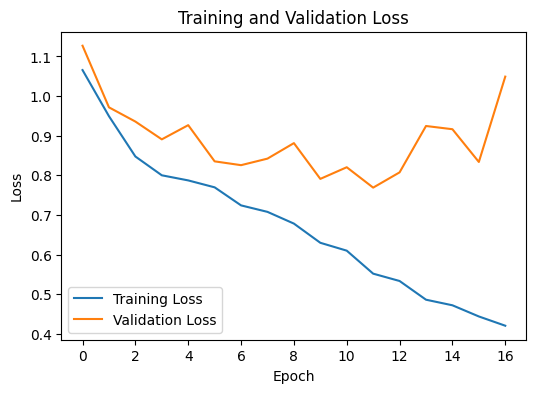

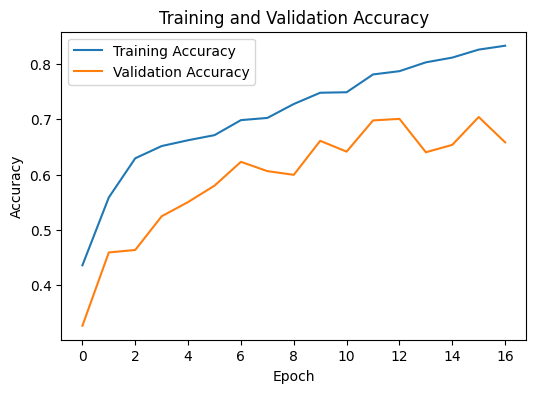

In [5]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

56/56 [==============================] - 4s 65ms/step
F1 Score:  0.6989117093307394
              precision    recall  f1-score   support

      barswa       0.58      0.76      0.66       612
      comsan       0.78      0.56      0.66       544
     eaywag1       0.80      0.76      0.78       629

    accuracy                           0.70      1785
   macro avg       0.72      0.69      0.70      1785
weighted avg       0.72      0.70      0.70      1785



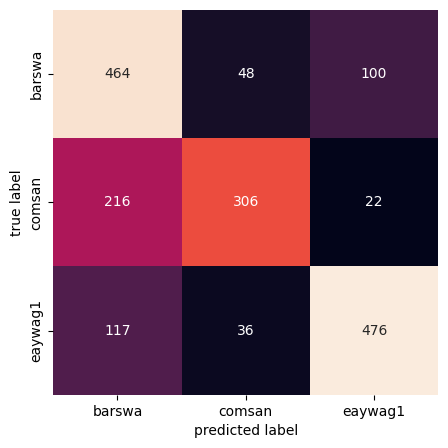

In [7]:
# Make predictions on the validation set
y_pred = np.argmax(model.predict(X_val_combined), axis=-1)
# Compute the F1 score
f1 = f1_score(y_val_encoded, y_pred, average='weighted')
print('F1 Score: ', f1)
# Display the classification report
print(classification_report(y_val_encoded, y_pred, target_names=label_encoder.classes_))
# Compute confusion matrix
confusion_mat = confusion_matrix(y_val_encoded, y_pred)

# Create a heatmap
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()
